In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#call library

import os
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

#from preprocesslib import preprocessEach, makeY

In [ ]:
import os
import pandas as pd
import numpy as np

'''
이런식으로 사용하면 됩니다.
from preprocesslib import preprocessEach, makeY
X = preprocessEach('overlap')
X bootstrap해서 -> X_final만든 후에
y = makeY('overlap', len(X_final))
'''

def preprocessEach(folder_name):
   # set file path
    folder_path = f'/content/drive/MyDrive/research/data/{folder_name}_clean'

    # load file name in folder
    file_names = os.listdir(folder_path)
    data_array = []

    for file in file_names:
        # set file path
        file_path = os.path.join(folder_path, file)
        
        # load csv file as dataframe
        df = pd.read_csv(file_path)

        #preprocessing column
        df['open-close'] = df['Open'] - df['Close'] #추가
        df['open-close'] = df['open-close'] + abs(min(df['open-close'])) #추가
        df['MA5'] = df['Close'].rolling(5).mean() #추가
        df['Diff'] = df['High'] - df['Low']
        df = df[['Close','Volume','Diff','open-close','MA5', 'Search']]
        df.fillna(0, inplace=True)

        #log transform
        df = np.log1p(df)

        #insert list to array
        data_array.append(df)

    return np.array(data_array)

def makeY(folder_name, filelength):

    if folder_name=='growth':
        yGrowths = np.ones(filelength)
        yValues = np.zeros(filelength)
    elif folder_name=='value':
        yGrowths = np.zeros(filelength)
        yValues = np.ones(filelength)
    elif folder_name=='overlap':
        yGrowths = np.ones(filelength)
        yValues = np.ones(filelength)

    y = np.column_stack([yGrowths.T, yValues.T])
    return y

In [ ]:
xGrowths = preprocessEach('growth')
xValues = preprocessEach('value')
xOverlaps = preprocessEach('overlap')

<ipython-input-3-0e061c61a26b>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.fillna(0, inplace=True)
<ipython-input-3-0e061c61a26b>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.fillna(0, inplace=True)


In [ ]:
#bootstrap
n_samples = len(xValues)
diff = len(xValues) - len(xGrowths)
xGrowths_bootstrapped = xGrowths[np.random.choice(len(xGrowths), size=diff, replace=True)]
xGrowths = np.concatenate((xGrowths, xGrowths_bootstrapped), axis=0)

diff = len(xValues) - len(xOverlaps)
xOverlaps_bootstrapped = xOverlaps[np.random.choice(len(xOverlaps), size=diff, replace=True)]
xOverlaps = np.concatenate((xOverlaps, xOverlaps_bootstrapped), axis=0)

In [ ]:
#make y values
yGrowths = makeY('growth', n_samples)
yValues = makeY('value', n_samples)
yOverlaps = makeY('overlap', n_samples)

In [ ]:
x = np.concatenate((xGrowths, xValues, xOverlaps), axis=0)
y = np.concatenate((yGrowths, yValues, yOverlaps), axis=0)

In [ ]:
#minmax scaling by element
scaler = MinMaxScaler()
for i in range(6):
    x[:,:,i] = scaler.fit_transform(x[:,:,i])

In [ ]:
def splitData(x, y, train_ratio=0.8):
    # shuffle data
    permutation = np.random.permutation(len(x))
    x = x[permutation]
    y = y[permutation]

    # split data
    n_train_samples = int(train_ratio * len(x))
    x_train, x_test = x[:n_train_samples], x[n_train_samples:]
    y_train, y_test = y[:n_train_samples], y[n_train_samples:]

    return x_train, x_test, y_train, y_test

In [ ]:
#model
model = Sequential()
model.add(LSTM(64, input_shape=(1248,6), return_sequences=False))
model.add(Dropout(0.4))
model.add(Dense(2, activation='sigmoid'))
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', save_best_only=True)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [ ]:
#split data for cross validation
def splitDataCrossVal(x, y, fold=3):
    # shuffle data
    permutation = np.random.permutation(len(x))
    x = x[permutation]
    y = y[permutation]

    x_split = []
    y_split = []
    # split data
    n_samples = int(len(x)/fold)
    for i in range(fold-1):
      x_split.append(x[i*n_samples:(i+1)*n_samples])
      y_split.append(y[i*n_samples:(i+1)*n_samples])
    x_split.append(x[(fold-1)*n_samples:])
    y_split.append(y[(fold-1)*n_samples:])

    return x_split, y_split

In [ ]:
#cross validation
x_split, y_split = splitDataCrossVal(x,y)
print(len(x_split))
accuracy_cross_val = []
for i in range(len(x_split)):
  x_train, x_test, y_train, y_test = splitData(x_split[i], y_split[i])
  x_train = pad_sequences(x_train, dtype='float32')
  x_test = pad_sequences(x_test, dtype='float32')
  x_train = np.nan_to_num(x_train, nan=0)
  x_test = np.nan_to_num(x_test, nan=0)

  history=model.fit(x_train, y_train, epochs=2000, batch_size=128, validation_split=0.2, callbacks=[es, mc])
  model=load_model('best_model.h5')
  loss, accuracy = model.evaluate(x_test, y_test)
  accuracy_cross_val.append(accuracy)
print("cross validation accuracy:{}".format(accuracy_cross_val))
print("average cross validation accuracy:{}".format(sum(accuracy_cross_val)/len(accuracy_cross_val)))

3
Epoch 1/2000
6/6 [==============================] - 4s 169ms/step - loss: 0.6692 - acc: 0.6520 - val_loss: 0.6553 - val_acc: 0.6395
Epoch 2/2000
6/6 [==============================] - 0s 65ms/step - loss: 0.6283 - acc: 0.6711 - val_loss: 0.6661 - val_acc: 0.6453
Epoch 3/2000
6/6 [==============================] - 0s 54ms/step - loss: 0.6311 - acc: 0.6535 - val_loss: 0.6545 - val_acc: 0.6279
Epoch 4/2000
6/6 [==============================] - 0s 57ms/step - loss: 0.6234 - acc: 0.6301 - val_loss: 0.6439 - val_acc: 0.6628
Epoch 5/2000
6/6 [==============================] - 0s 59ms/step - loss: 0.6223 - acc: 0.6345 - val_loss: 0.6384 - val_acc: 0.6453
Epoch 6/2000
6/6 [==============================] - 0s 51ms/step - loss: 0.6140 - acc: 0.6491 - val_loss: 0.6302 - val_acc: 0.6221
Epoch 7/2000
6/6 [==============================] - 0s 51ms/step - loss: 0.6178 - acc: 0.5073 - val_loss: 0.6305 - val_acc: 0.5581
Epoch 8/2000
6/6 [==============================] - 0s 51ms/step - loss: 0.6050 

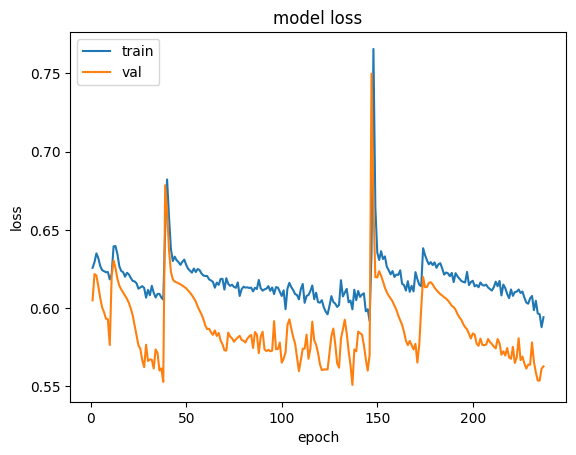

In [ ]:
epochs = range(1, len(history.history['acc']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

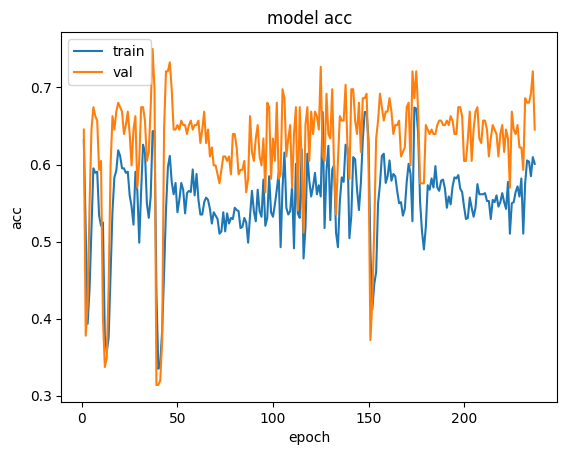

In [ ]:
epochs = range(1, len(history.history['acc']) + 1)
plt.plot(epochs, history.history['acc'])
plt.plot(epochs, history.history['val_acc'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()